# Report 2

## Title to be here

<a href = http://www.icpsr.umich.edu/icpsrweb/ICPSR/series/64>Link to NSDUH Website</a>

<a href = http://www.icpsr.umich.edu/icpsrweb/ICPSR/ssvd/studies/36361/variables>Variable list link</a>

In [1]:
""" This file contains code used to analyze the
2014 NSDUH Survey, the information for which can be found at this link:
http://www.icpsr.umich.edu/icpsrweb/ICPSR/series/64

The following packages are required to run this code.
"""

from __future__ import print_function, division
import pandas as pd

import sys
import numpy as np
import thinkstats2
import thinkplot
import matplotlib.pyplot as plt
from operator import itemgetter
from cycler import cycler

from collections import defaultdict


In [2]:
def ReadNSDUH():
    """ Reads the NSDUH file.
    TO DO: make a clean file function

    returns a Dataframe
    """
    nsduh = pd.read_stata('reports/report2data/ICPSR_36361/DS0001/36361-0001-Data.dta',convert_categoricals=False, convert_missing=False)
    #CleanNSDUH(nsduh)
    return nsduh

def CleanNSDUH(df):
    """ Given a dataframe and a list of variables to clean, replaces -9 with nans. """
    na_vals = [985,991, 994, 997, 999, 81, 85, 89, 91, 94, 97, 98, 99, -9]
    for column in df:
        df[column].replace(na_vals, np.nan, inplace = True)

In [19]:
def CleanData(df):
    na_vals = [981 , 989 , 991 , 994 , 997 , 998 , 999]
    
    df.TXALONAG.replace(na_vals, np.nan, inplace=True)
    df.TXDRONAG.replace(na_vals, np.nan, inplace=True)
    df.TXALCDAG.replace(na_vals, np.nan, inplace=True)
    df.TXDRGAAG.replace(na_vals, np.nan, inplace=True)
    df.TXYALAGE.replace(na_vals, np.nan, inplace=True)
    df.TXYALDRG.replace(na_vals, np.nan, inplace=True)
    df.TXYALDAG.replace(na_vals, np.nan, inplace=True)
    df.TXYDRAGE.replace(na_vals, np.nan, inplace=True)
    df.TXYDRALC.replace(na_vals, np.nan, inplace=True)
    df.TXYDRAAG.replace(na_vals, np.nan, inplace=True)
    df.TXYADAAG.replace(na_vals, np.nan, inplace=True)
    df.TXYADDAG.replace(na_vals, np.nan, inplace=True)
    
    df.CABNGAGE.replace(na_vals, np.nan, inplace=True)
    df.CIGAGE.replace(na_vals, np.nan, inplace=True)
    df.SUMAGE.replace(na_vals, np.nan, inplace=True)
    df.SUMYFU.replace([9999], np.nan, inplace=True)
    
    df['agetreatment']=df.TXDRGAAG
    df['agedruguse']=df.SUMAGE
    df['yearsofuseTX']=df.agetreatment-df.agedruguse
    df['yearssincefirst']=2014-df.SUMYFU

    #df['agetreatment']=AssignNonNanMin([df.TXALCDAG, df.TXDRGAAG, df.TXDRONAG, df.TXALONAG])
    #df['agedruguse']=AssignNonNanMin([df.CABNGAGE, df.CIGAGE, df.SUMAGE])
    
def MakeAged(df):
    ongoing = df[df.TXEVER == 2]
    complete = df[df.TXEVER == 1]
    
    for i in range(len(complete.CASEID)):
        temp = complete.iloc[i]
        tx_list = [x for x in [temp.TXALONAG,temp.TXDRONAG,temp.TXALCDAG,
                                 temp.TXDRGAAG,temp.TXYALAGE,temp.TXYALDRG,
                                 temp.TXYALDAG,temp.TXYDRAGE,temp.TXYDRALC,
                                 temp.TXYDRAAG,temp.TXYADAAG,temp.TXYADDAG] if np.logical_not(np.isnan(x))]
        dr_list = [x for x in [temp.CABNGAGE,temp.CIGAGE, temp.SUMAGE] if np.logical_not(np.isnan(x))]
        if len(dr_list)>0 and len(tx_list)>0:
            complete.iloc[i].agetreatment = np.min(tx_list)
            complete.iloc[i].agedruguse = np.min(dr_list)
            complete.iloc[i].yearsofuseTX = complete.iloc[i].agetreatment - complete.iloc[i].agedruguse
        else:
            complete.iloc[i].yearsofuseTX = np.nan
        
    for i in range(len(ongoing.CASEID)):
        temp = ongoing.iloc[i]
        dr_list = [x for x in [temp.CABNGAGE,temp.CIGAGE, temp.SUMAGE] if np.logical_not(np.isnan(x))]
        if len(dr_list)>0:
            ongoing.iloc[i].agedruguse = np.min(dr_list)
            ongoing.iloc[i].yearssincefirst = 2014 - ongoing.iloc[i].agedruguse
        else:
            ongoing.iloc[i].yearssincefirst = np.nan
        
    return ongoing, complete

In [4]:
nsduh = ReadNSDUH()

In [ ]:
hist_treatment = thinkstats2.Hist(nsduh.TXEVER)
print((hist_treatment[1]/(hist_treatment[1]+hist_treatment[2]))*100)

In [20]:
CleanData(nsduh)
ongoing, complete = MakeAged(nsduh)

/home/kaitlyn/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


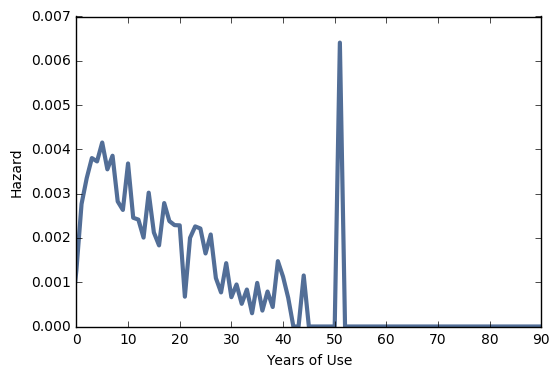

In [25]:
hf = EstimateHazardFunction(complete.yearsofuseTX.dropna(), ongoing.yearssincefirst.dropna())
thinkplot.Plot(hf)
thinkplot.Config(xlabel='Years of Use',
                 xlim=[0,90],
                 ylabel='Hazard')
thinkplot.Show()

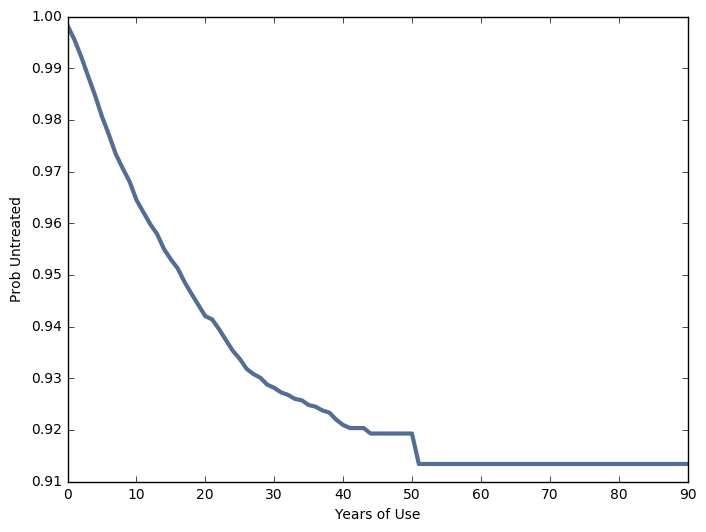

In [27]:
sf = hf.MakeSurvival()
thinkplot.Plot(sf)
thinkplot.Config(xlabel='Years of Use',
                 xlim = [0, 90],
                 ylabel='Prob Untreated')

thinkplot.Show()

In [28]:
def AddLabelsByIncome(groups, **options):
    """Draws fake points in order to add labels to the legend.

    groups: GroupBy object
    """
    labels = {1:'Below Poverty Line', 2:'Middle Income', 3:'Double and Above', -9:'College Student'}
    thinkplot.PrePlot(len(groups))
    for name, _ in groups:
        thinkplot.Plot([15], [1], label=labels[name], **options)

def EstimateGroupSurvival(resp):
    """Estimates the survival curve.

    resp: DataFrame of respondents

    returns: pair of HazardFunction, SurvivalFunction
    """
    # NOTE: Filling missing values would be better than dropping them.
    ongoing, complete = MakeAged(nsduh)

    hf = EstimateHazardFunction(complete.yearsofuseTX.dropna(), ongoingyearssincefirst.dropna())
    sf = hf.MakeSurvival()

    return hf, sf

def PlotPredictionsByIncome(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    hfs = []
    for _, group in groups:
        hf, sf = EstimateGroupSurvival(group)
        hfs.append(hf)

    thinkplot.PrePlot(len(hfs))
    for i, hf in enumerate(hfs):
        if i > 0:
            hf.Extend(hfs[i-1])
        sf = hf.MakeSurvival()
        thinkplot.Plot(sf, **options)

In [ ]:
groups = nsduh.groupby('POVERTY2')
PlotPredictionsByIncome(groups)

AddLabelsByIncome(groups, alpha=0.7)
thinkplot.Config(xlabel='Years of Use',
                 xlim = [0, 90],
                 ylabel='Prob Untreated',
                 ylim=[0.8, 1])
thinkplot.Show()

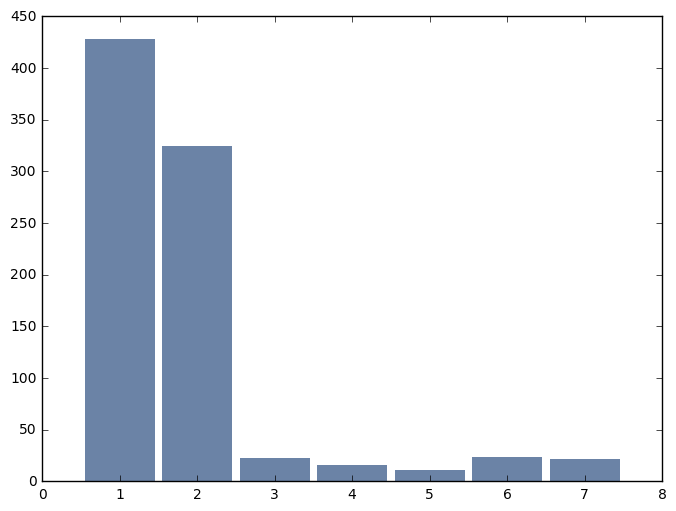

In [53]:
hist_outpatient = thinkstats2.Hist(nsduh[nsduh.TXLTYOU2 < 10].TXLTYOU2.dropna())
thinkplot.Hist(hist_outpatient)
#thinkplot.Config(axis = [0, 8, 0, 500])
thinkplot.show()

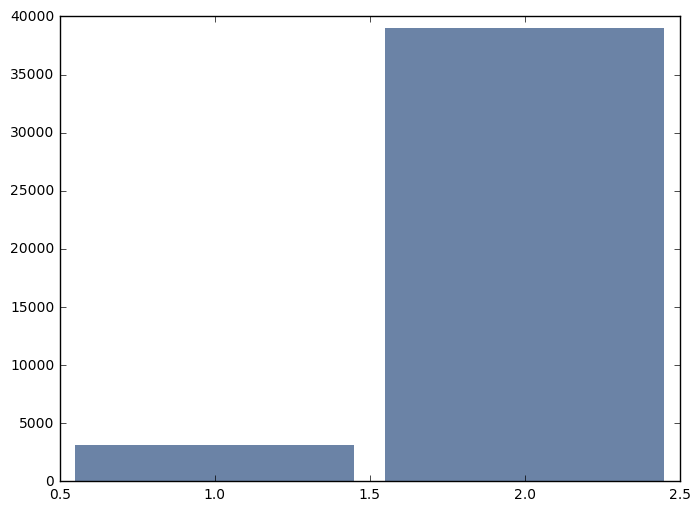

In [51]:
hist_treatment = thinkstats2.Hist(nsduh.TXEVER.dropna())
thinkplot.Hist(hist_treatment)
thinkplot.show()

Does the age at which someone first started smoking a cigarette have any effect on their consumption of other drugs? (CIGTRY, COCYRTOT, CRKYRTOT, etc)

What sort of relationship is there between mental health and frequency of drug use?

How effective is care (when people are in inpatient, does it decrease use? what about outpatient)? (TXLTYOU2, NDMRLMCV,NDMRTYPE, TXLTY___, HLTINMNT, AUPOPFRE,AMHTXRC3)

Is there a connection between treatment result (TXLTYOU2) and whether or not they were able to recieve additional treatment based on their healthcare plan or was otherwise unavailable (TXRNLMCV, TXRNTYPE)?

TXALCDEV, TXALCDAG, TXDRGAEV, and TXDRGAAG pertain to respondents who
were lifetime users of alcohol and other drugs. (Age first recieved treatment)
CABNGAGE: age when first had 5+ drinks one occasion. Used to indicate potential alcohol problem.
CIGAGE: used to indicate the start of a smoking problem (Cigs used every day)
SUMAGE: used for age of first use of illicit drugs in general
POVERTY2: 1 means poverty, 2 means up to 2x poverty line income, 3 means >2x pov line income

In [54]:
nsduh.TXLASREC.dropna()

12       3.0
13       2.0
18       3.0
50       3.0
68       7.0
72       3.0
113      3.0
138      7.0
139      3.0
142      3.0
246      3.0
265      3.0
290      3.0
299      3.0
312      8.0
337      7.0
341      3.0
357      3.0
372      3.0
373      7.0
379      2.0
380      3.0
383      3.0
390      3.0
397      1.0
411      3.0
445      3.0
448      3.0
459      3.0
467      3.0
        ... 
54532    3.0
54554    3.0
54560    2.0
54654    3.0
54656    3.0
54677    3.0
54719    3.0
54745    3.0
54747    3.0
54781    1.0
54787    3.0
54810    3.0
54824    3.0
54841    7.0
54842    3.0
54846    3.0
54857    3.0
54885    7.0
54897    2.0
54947    3.0
55013    3.0
55068    3.0
55088    3.0
55096    3.0
55120    3.0
55208    3.0
55219    3.0
55247    3.0
55263    3.0
55267    2.0
Name: TXLASREC, dtype: float64

In [65]:
np.min(nsduh.CIGTRY.dropna())
np.isnan(nsduh.TXALCDEV[1])

True

In [109]:
CleanData(nsduh)

In [93]:
ongoing = nsduh[(nsduh.TXDRGAEV != 1)&(nsduh.TXDRGAEV != 11)].yearssincefirst.dropna()
hastreatment = nsduh[(nsduh.TXDRGAEV == 1)|(nsduh.TXDRGAEV == 11)].yearsofuse.dropna()

In [21]:
from collections import Counter
import survival

def EstimateHazardFunction(complete, ongoing, label='', verbose=False):
    """Estimates the hazard function by Kaplan-Meier.

    http://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator

    complete: list of complete lifetimes
    ongoing: list of ongoing lifetimes
    label: string
    verbose: whether to display intermediate results
    """
    if np.sum(np.isnan(complete)):
        raise ValueError("complete contains NaNs")
    if np.sum(np.isnan(ongoing)):
        raise ValueError("ongoing contains NaNs")

    hist_complete = Counter(complete)
    hist_ongoing = Counter(ongoing)

    ts = list(hist_complete | hist_ongoing)
    ts.sort()

    at_risk = len(complete) + len(ongoing)

    lams = pd.Series(index=ts)
    for t in ts:
        ended = hist_complete[t]
        censored = hist_ongoing[t]

        lams[t] = ended / at_risk
        if verbose:
            print(t, at_risk, ended, censored, lams[t])
        at_risk -= ended + censored

    return survival.HazardFunction(lams, label=label)

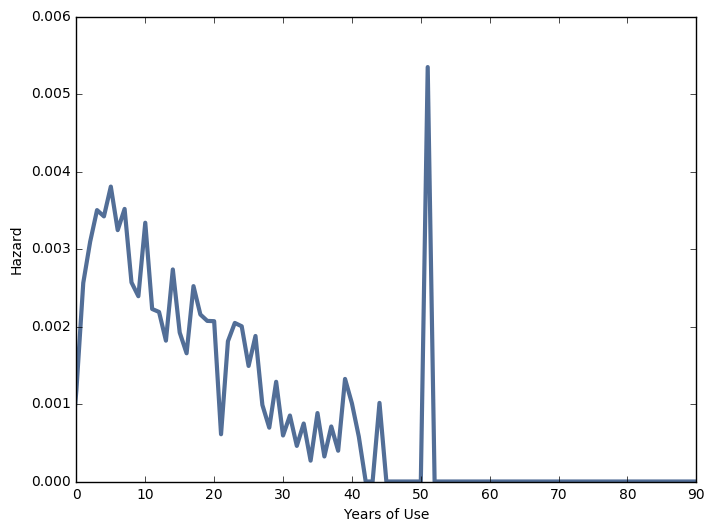

In [105]:
hf = EstimateHazardFunction(hastreatment, ongoing)
thinkplot.Plot(hf)
thinkplot.Config(xlabel='Years of Use',
                 xlim=[0,90],
                 ylabel='Hazard')
thinkplot.Show()

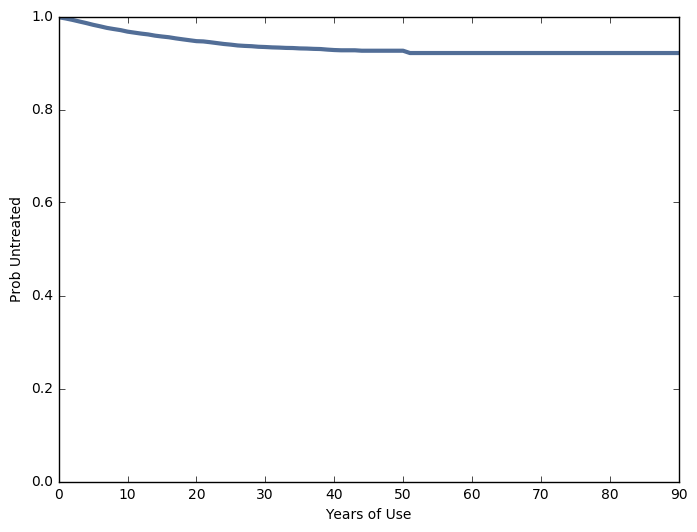

In [106]:
sf = hf.MakeSurvival()
thinkplot.Plot(sf)
thinkplot.Config(xlabel='Years of Use',
                 xlim = [0, 90],
                 ylabel='Prob Untreated',
                 ylim=[0, 1])

thinkplot.Show()

In [112]:
pov = nsduh[nsduh.POVERTY2 == 1]

mid = nsduh[(nsduh.POVERTY2 == 2)|(nsduh.POVERTY2 == -9)]

w = nsduh[nsduh.POVERTY2 == 3]

In [113]:
p_hf = EstimateHazardFunction(pov_treat, pov_on)
p_sf = p_hf.MakeSurvival()

m_hf = EstimateHazardFunction(mid_treat, mid_on)
m_sf = m_hf.MakeSurvival()

w_hf = EstimateHazardFunction(w_treat, w_on)
w_sf = w_hf.MakeSurvival()

In [117]:
def AddLabelsByIncome(groups, **options):
    """Draws fake points in order to add labels to the legend.

    groups: GroupBy object
    """
    labels = {1:'Below Poverty Line', 2:'Middle Income', 3:'Double and Above', -9:'College Student'}
    thinkplot.PrePlot(len(groups))
    for name, _ in groups:
        thinkplot.Plot([15], [1], label=labels[name], **options)

def EstimateGroupSurvival(resp):
    """Estimates the survival curve.

    resp: DataFrame of respondents

    returns: pair of HazardFunction, SurvivalFunction
    """
    # NOTE: Filling missing values would be better than dropping them.
    ongoing = resp[(resp.TXDRGAEV != 1)&(resp.TXDRGAEV != 11)].yearssincefirst.dropna()
    complete = resp[(resp.TXDRGAEV == 1)|(resp.TXDRGAEV == 11)].yearsofuseTX.dropna()

    hf = EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

def PlotPredictionsByIncome(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    hfs = []
    for _, group in groups:
        hf, sf = EstimateGroupSurvival(group)
        hfs.append(hf)

    thinkplot.PrePlot(len(hfs))
    for i, hf in enumerate(hfs):
        if i > 0:
            hf.Extend(hfs[i-1])
        sf = hf.MakeSurvival()
        thinkplot.Plot(sf, **options)

In [127]:
groups = nsduh.groupby('POVERTY2')
PlotPredictionsByIncome(groups)

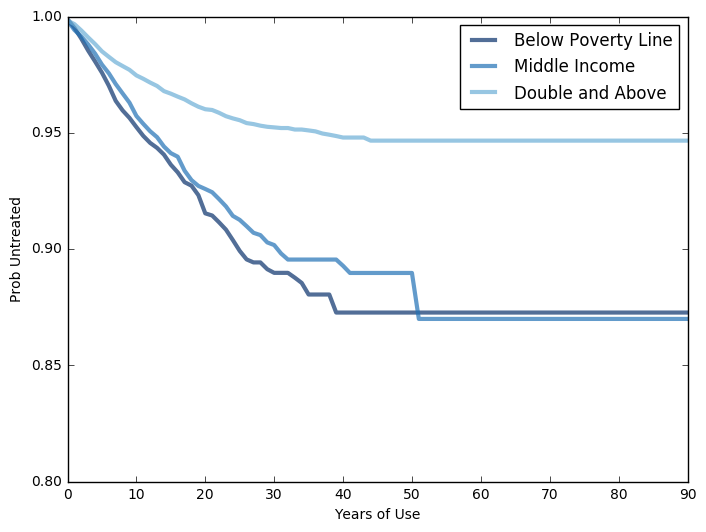

In [128]:
AddLabelsByIncome(groups, alpha=0.7)
thinkplot.Config(xlabel='Years of Use',
                 xlim = [0, 90],
                 ylabel='Prob Untreated',
                 ylim=[0.8, 1])
thinkplot.Show()